<h1 align='center'> Excutive summary</h1>
Project Gutenberg is a significant initiative aimed at preserving cultural heritage by converting old literature into eBook format. This project involved analyzing a corpus of 1176 books to extract essential information about each book, including details about the author, title, word count, and number of unique words.<

To gain insights into the writing styles of various authors, we identified the top 10 writers based on their works. Comparing their writing styles with those of other authors, we sought to discern distinctive characteristics that set them apart.

Additionally, we conducted an analysis to determine the top 10 most frequently used words across all the books in the corpus. This provided valuable information about common themes or language patterns prevalent throughout the collection.

Further investigation led us to focus on the writing style of the most frequently repeated author, W.W. Jacobs. Through a detailed examination of his works, we found that his writing style is characterized by a natural tone.

Furthermore, we attempted to analyze the lexical diversity over the years to understand how language and writing styles evolved. However, we encountered challenges in obtaining precise publishing dates, as the available data represented the date of conversion to eBook format rather than the original publication date. Consequently, we were unable to establish a consistent pattern for tracking lexical changes over time.

In conclusion, this project has provided valuable insights into the literary works available through Project Gutenberg. By analyzing writing styles and frequently used words, we have gained a deeper understanding of the corpus's content and notable authors. Our efforts to uncover the writing style of W.W. Jacobs further contributed to this exploration. While challenges prevented a comprehensive analysis of lexical diversity over the years, the project remains a valuable endeavor in preserving and appreciating classic literature.


## Data Cleaning and Preparations

In [1]:
import os
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import nltk
from nltk.book import *
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


## Get author name, title, relase date for each book (Basic information)


In [3]:
#author, title, and relase date going to be a columns in data frame hold basic information about each book
author = []
title = []
relase_date = []
language = []
indices  = []  #we will use this list as an index for data frame which we willuse it to store basic informations about each book.
files = os.listdir("dataset")
for file in files:
    indices.append(int(file.split(".")[0])) #we need just first part from the file name and then convert it to "int" to use as index.
    with open('dataset/'+file,'r') as fid:
        for line in fid: 
            # the format for title is "Titl: book title"
            if 'Title:' in line: 
                #after strip the line at : the list returned, we append the second index in our new list, and strip it to remove white space and new line "\n"
                title.append(line.split(":")[1].strip()) if len(line.split(":"))>=2 else title.append(np.nan)
            elif "Author:" in line:
                author.append(line.split(":")[1].strip()) if len(line.split(":"))>=2 else author.append(np.nan)
            elif 'Release Date:' in line:
                Relase_Date = line.split(":")[1].strip()
                cleaned_release_date = Relase_Date.split('[')
                relase_date.append(cleaned_release_date[0]) if len(cleaned_release_date)>=2 else relase_date.append(np.nan)
            elif 'Language:' in line and ':' in line:
                language.append(line.split(":")[1].strip()) if len(line.split(":"))>=2 else language.append(np.nan)
                break # we no longer need to loop over the rest of file we got all we need.


In [4]:
language = pd.array(language)
language.value_counts()  #as we notice that most books in English so there is no need to add it datafram

English                 1174
English and Aleutian       1
Spanish and English        1
dtype: Int64

In [5]:
#ensure that all list lenght are the same before construct data frame.
print(f'the lenght of author is :{len(author)},title is :{len(title)},and relase date is: {len(relase_date)}')  

the lenght of author is :1176,title is :1176,and relase date is: 1176


In [6]:
book_info = pd.DataFrame({'title':title,'Author':author, 'relase_date':relase_date}, index = indices)

In [7]:
book_info.head()

,title,Author,relase_date
10001,Apocolocyntosis,Lucius Seneca,"November 10, 2003"
10002,The House on the Borderland,William Hope Hodgson,"November 10, 2003"
10003,"My First Years As A Frenchwoman, 1876-1879",Mary King Waddington,"November 10, 2003"
10004,The Warriors,"Lindsay, Anna Robertson Brown","November 10, 2003"
10005,A Voyage to the Moon,George Tucker,"November 7, 2003"


## change relase date to date format.

In [8]:
book_info['relase_date'] = pd.to_datetime(book_info['relase_date'].str.strip(), format="%B %d, %Y")

In [9]:
book_info.head()

,title,Author,relase_date
10001,Apocolocyntosis,Lucius Seneca,2003-11-10
10002,The House on the Borderland,William Hope Hodgson,2003-11-10
10003,"My First Years As A Frenchwoman, 1876-1879",Mary King Waddington,2003-11-10
10004,The Warriors,"Lindsay, Anna Robertson Brown",2003-11-10
10005,A Voyage to the Moon,George Tucker,2003-11-07


### getting Books body to start analysis it.

## Functions

In [10]:
#this function gives us the body of the story without introduction and tail. 
def getting_text(file):
    book = ''
    fetch = False
    with open('dataset/'+file,'r') as fid:
        for line in fid:
            #all books end by one of these statments,and after this line is just a header of Gutenburg porject it self so I break book after return book as a generator. 
            if 'End of the Project Gutenberg' in line or 'End of Project Gutenberg' in line or '***END OF THE PROJECT' in line or '*** END OF THE PROJECT' in line: 
                yield book  #I return book as a generator to save memory and get hight performance.
                break
            if fetch :
                book += line
                #every book start with one of these lines, so from this line will construct text
            if '*** START OF TH' in line or '***START OF TH' in line:
                fetch = True  #make this variable true to start construct book, and this will help us to avoid analysis the introduction of each book.

In [11]:
sw = stopwords.words("english")  #get stop words to use it in filtering.
#initiate a tokenizer, I put it outside the function to avoid repeated it every time I called the function.
reg_toknize = RegexpTokenizer('[a-z]{3,}|[A-Z]{3,}') #we just choose words with more than 3 letters which it is form a meaningful word, that permits us to get the writer's sentiment.

In [12]:
#this function responsable to build word and sentence tokenizations
def tokenization(text, typ):
    book = ''
    for line in text:
        book += line
    if typ == 'w':
        book_toknize = reg_toknize.tokenize(book) 
        filter_toknize = [word for word in book_toknize if not word.lower() in sw] 
        return filter_toknize  
    elif typ == 's':
        book = book.replace('\n',' ')   #replace break lines form text
        book = book.replace(string.punctuation,' ')  #remove all punctuation from text.
        sentence_toknize = nltk.tokenize.sent_tokenize(book)
        return sentence_toknize      

In [13]:
#this fucntion reponsable to get statistics about each book the retrun it as list
def get_words_stat(filter_tok_book):
    n_words = len(filter_tok_book)
    n_unique = len(set(filter_tok_book))
    if n_words > 0 and n_unique > 0:
        lex_div = round(n_unique/n_words,2)
    else :
        lex_div = 0     #in case book is empty, not raise an error
    fdist = FreqDist(filter_tok_book)  #it is a NLTK class so i turned it to dictonary,
    n_hapaxes = len(fdist.hapaxes())
    fdist = dict(fdist)
    return [n_words, n_unique, lex_div,top_10_words(fdist),n_hapaxes]

In [14]:
#this function takes dictionary of top words from "get words stat" function and return the top 10 words
def top_10_words(dic):
    top_10 = []
    for k,v in dic.items():
        top_10.append([v,k])
    top_10.sort(reverse=True)
    return top_10[:10]

In [15]:
#in this funciton I just get all text files from my local desk and store it dictinary to prepare constsruct data frame.
def get_files():
    files = os.listdir("dataset")
    for file in files:
        text = getting_text(file)
        index = int(file.split('.')[0])
        books[index] = text
    

### store all text of book inside dictionary to get stats for each book

In [16]:
books = {}  #dictinary to store all books inside it
get_files()

In [17]:
len(files) == len(books)  # to be sure that every file represented into dictionary

True

In [18]:
# intiate dictinary to use use it in forming data frame.
book_stats  = {'n_words':[], 'n_unique':[], 'lex_div':[], 'most_repeated_words':[],'n_hapaxes':[]}

In [19]:
#start to iterate over all files.
for book in books.values():
    #get the tokanization of the book
    words_tok = tokenization(book,'w')
    #get stats of the book, send the tokanization to get stat function
    book_stat = get_words_stat(words_tok)
    #store return values in the dictionary
    book_stats['n_words'].append(book_stat[0])
    book_stats['n_unique'].append(book_stat[1])
    book_stats['lex_div'].append(book_stat[2])
    book_stats['most_repeated_words'].append(book_stat[3])
    book_stats['n_hapaxes'].append(book_stat[4]) 

In [20]:
#builds data fram about books statistics.
df_stats = pd.DataFrame(book_stats,index=indices )

In [21]:
df_stats.head(10)

,n_words,n_unique,lex_div,most_repeated_words,n_hapaxes
10001,2737,1510,0.55,"[[32, laudius], [25, one], [21, made], [19, oo...",1044
10002,24357,5091,0.21,"[[174, could], [155, time], [145, seemed], [14...",2465
10003,30656,6029,0.20,"[[420, one], [225, would], [214, always], [207...",2965
10004,24458,6818,0.28,"[[280, man], [269, one], [230, work], [217, li...",3781
10005,32561,7633,0.23,"[[291, one], [196, would], [167, rahmin], [146...",3341
10006,6170,2790,0.45,"[[73, thou], [38, love], [35, one], [31, time]...",1751
10008,33613,7880,0.23,"[[356, said], [184, one], [183, could], [175, ...",3960
10009,41471,8028,0.19,"[[297, upon], [279, one], [237, old], [212, li...",3783
10010,5182,2459,0.47,"[[41, may], [36, HOWARD], [35, spirit], [27, l...",1529
10011,13972,1078,0.08,"[[277, hot], [277, add], [270, cup], [252, sal...",384


In [22]:
#change data types to float to plot them without raising errors.
df_stats[['n_words','n_unique','lex_div','n_hapaxes']].astype('float64', copy= False)

,n_words,n_unique,lex_div,n_hapaxes
10001,2737.0,1510.0,0.55,1044.0
10002,24357.0,5091.0,0.21,2465.0
10003,30656.0,6029.0,0.20,2965.0
10004,24458.0,6818.0,0.28,3781.0
10005,32561.0,7633.0,0.23,3341.0
...,...,...,...,...
12380,39610.0,9272.0,0.23,4643.0
12381,24625.0,5485.0,0.22,2597.0
12383,63509.0,13261.0,0.21,6575.0
12385,59839.0,9920.0,0.17,4326.0


In [23]:
df_stats.describe()

,n_words,n_unique,lex_div,n_hapaxes
count,1176.000000,1176.000000,1176.000000,1176.000000
mean,28166.926871,5825.628401,0.309898,2946.098639
std,29500.984949,3869.881592,0.158402,1803.460680
min,45.000000,29.000000,0.050000,17.000000
25%,6834.000000,3386.250000,0.200000,2009.000000
50%,21667.000000,5204.000000,0.260000,2672.000000
75%,40939.000000,7994.250000,0.390000,3794.500000
max,464562.000000,50812.000000,0.890000,27504.000000


### Exploratory Data Analysis 

##  merge two data frames to get the final one which we will work with.

In [24]:
df = book_info.join(df_stats, how='left')

In [25]:
df.head()

,title,Author,relase_date,n_words,n_unique,lex_div,most_repeated_words,n_hapaxes
10001,Apocolocyntosis,Lucius Seneca,2003-11-10,2737,1510,0.55,"[[32, laudius], [25, one], [21, made], [19, oo...",1044
10002,The House on the Borderland,William Hope Hodgson,2003-11-10,24357,5091,0.21,"[[174, could], [155, time], [145, seemed], [14...",2465
10003,"My First Years As A Frenchwoman, 1876-1879",Mary King Waddington,2003-11-10,30656,6029,0.20,"[[420, one], [225, would], [214, always], [207...",2965
10004,The Warriors,"Lindsay, Anna Robertson Brown",2003-11-10,24458,6818,0.28,"[[280, man], [269, one], [230, work], [217, li...",3781
10005,A Voyage to the Moon,George Tucker,2003-11-07,32561,7633,0.23,"[[291, one], [196, would], [167, rahmin], [146...",3341


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 10001 to 12386
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                1176 non-null   object        
 1   Author               1176 non-null   object        
 2   relase_date          1174 non-null   datetime64[ns]
 3   n_words              1176 non-null   int64         
 4   n_unique             1176 non-null   int64         
 5   lex_div              1176 non-null   float64       
 6   most_repeated_words  1176 non-null   object        
 7   n_hapaxes            1176 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 115.0+ KB


In [27]:
df[df.n_words == 0].count() #in get stats function I made a condition if empty file return number of words = zero, so i used this condition to check if there is a missing value.

title                  0
Author                 0
relase_date            0
n_words                0
n_unique               0
lex_div                0
most_repeated_words    0
n_hapaxes              0
dtype: int64

### from the previous two queries, we are sure there are no missing values in the data frame.

# Descriptive Analytics

## who is the most writer has books?

In [28]:
Author_counts = df.Author.value_counts()[:10]
Author_counts

Various                 201
W.W. Jacobs              52
Anonymous                30
Roger McGuinn            30
John Lord                14
Charles Kingsley         14
Unknown                  11
James D. Richardson       8
Arthur Schopenhauer       7
Richard Le Gallienne      7
Name: Author, dtype: int64

<AxesSubplot:xlabel='Author'>

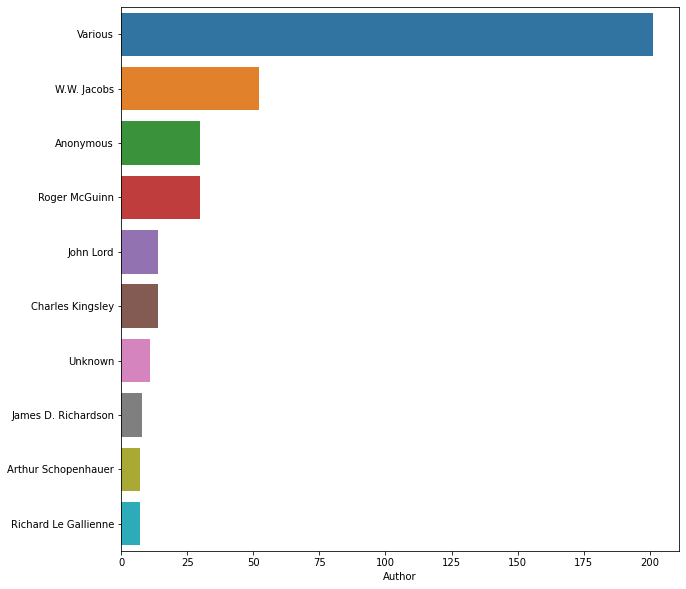

In [29]:
plt.figure(figsize=(10,10))
sns.barplot(y = Author_counts.index, x = Author_counts)

* as we noted from the above graph there are many books we can't know their author names, so we will use the available writer's names to know more about their writing style and we going to compare them with other writers.

In [30]:
#remove book with unkown authors
top_authors = list(Author_counts.index)   
top_authors = [x for x in top_authors if x not in ['Various','Anonymous','Unknown']] 
top_authors

['W.W. Jacobs',
 'Roger McGuinn',
 'John Lord',
 'Charles Kingsley',
 'James D. Richardson',
 'Arthur Schopenhauer',
 'Richard Le Gallienne']

### what is the number of words, unique words, and lex_diversity, number of hapaxes (the number of words appear once in the text) relative to other authors?

In [31]:
#create data frame with top authors only
df_top_authors = df[df.Author.isin(top_authors)]
display(df_top_authors.head())
display(df_top_authors.info())

,title,Author,relase_date,n_words,n_unique,lex_div,most_repeated_words,n_hapaxes
10116,All Saints' Day and Other Sermons,Charles Kingsley,2003-11-17,49985,6971,0.14,"[[542, man], [393, ord], [378, hrist], [357, g...",3062
10251,Town Geology,Charles Kingsley,2003-11-24,20334,4746,0.23,"[[159, may], [147, one], [146, sea], [143, wou...",2400
10325,The Gospel of the Pentateuch,Charles Kingsley,2003-11-27,24067,4313,0.18,"[[315, man], [229, ord], [219, men], [185, may...",2010
10326,David,Charles Kingsley,2003-11-27,6785,2525,0.37,"[[136, avid], [95, man], [58, ord], [47, life]...",1467
10348,Audio,Roger McGuinn,2004-01-08,227,180,0.79,"[[5, sea], [4, work], [4, must], [4, money], [...",150


<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 10116 to 11481
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                132 non-null    object        
 1   Author               132 non-null    object        
 2   relase_date          132 non-null    datetime64[ns]
 3   n_words              132 non-null    int64         
 4   n_unique             132 non-null    int64         
 5   lex_div              132 non-null    float64       
 6   most_repeated_words  132 non-null    object        
 7   n_hapaxes            132 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 9.3+ KB


None

In [32]:
df_other_authors = df[~df.Author.isin(top_authors)]
display(df_other_authors.head())
display(df_other_authors.info())

,title,Author,relase_date,n_words,n_unique,lex_div,most_repeated_words,n_hapaxes
10001,Apocolocyntosis,Lucius Seneca,2003-11-10,2737,1510,0.55,"[[32, laudius], [25, one], [21, made], [19, oo...",1044
10002,The House on the Borderland,William Hope Hodgson,2003-11-10,24357,5091,0.21,"[[174, could], [155, time], [145, seemed], [14...",2465
10003,"My First Years As A Frenchwoman, 1876-1879",Mary King Waddington,2003-11-10,30656,6029,0.20,"[[420, one], [225, would], [214, always], [207...",2965
10004,The Warriors,"Lindsay, Anna Robertson Brown",2003-11-10,24458,6818,0.28,"[[280, man], [269, one], [230, work], [217, li...",3781
10005,A Voyage to the Moon,George Tucker,2003-11-07,32561,7633,0.23,"[[291, one], [196, would], [167, rahmin], [146...",3341


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 10001 to 12386
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                1044 non-null   object        
 1   Author               1044 non-null   object        
 2   relase_date          1042 non-null   datetime64[ns]
 3   n_words              1044 non-null   int64         
 4   n_unique             1044 non-null   int64         
 5   lex_div              1044 non-null   float64       
 6   most_repeated_words  1044 non-null   object        
 7   n_hapaxes            1044 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 73.4+ KB


None

### what is the difference between the number of words and lex_diversity  in top authors and others?

In [33]:
#to when I draw the below digram for the first time I found there is outliersm, thus I used these to condition to filter the numbers of words. 
filtered_n_words_top = df_top_authors[(df_top_authors['n_words']<4000) & (df_top_authors['n_words']>500)]['n_words']
filtered_n_words_others = df_other_authors[(df_other_authors['n_words']<5000) & (df_other_authors['n_words']>500)]['n_words']

Text(0.5, 1.0, 'n words for other Auth.')

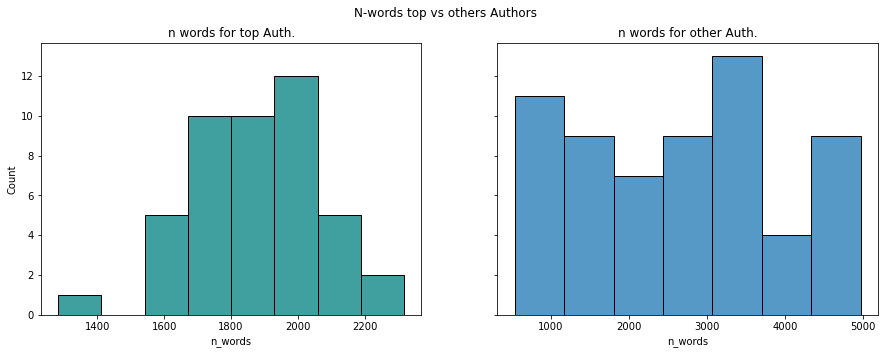

In [34]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('N-words top vs others Authors')

sns.histplot(ax=axes[0],x=filtered_n_words_top,color='teal')
axes[0].set_title('n words for top Auth.')

sns.histplot(ax=axes[1],x=filtered_n_words_others)
axes[1].set_title('n words for other Auth.')


Text(0.5, 1.0, 'lex dev. for other Auth.')

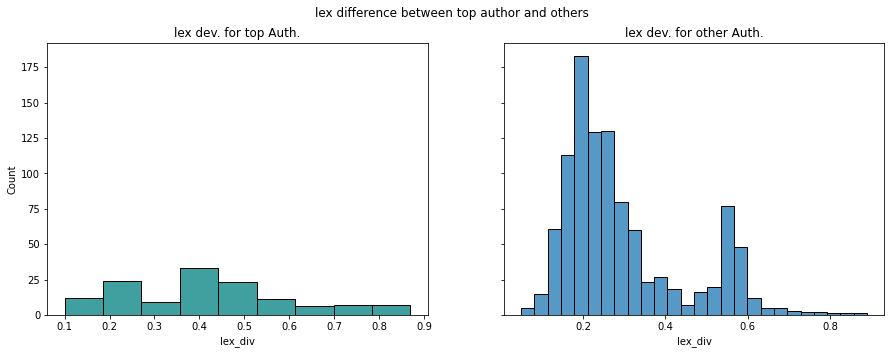

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('lex difference between top author and others')

sns.histplot(ax=axes[0],x=df_top_authors['lex_div'],color='teal')
axes[0].set_title('lex dev. for top Auth.')

sns.histplot(ax=axes[1],x=df_other_authors['lex_div'])
axes[1].set_title('lex dev. for other Auth.')


<p>the previous two diagrams we can conclude the peak of the number of words of the top author is 2000 words, and the peak of the other writers is near 3500.</p>
<p>on the other hand, the peak of lexical diversity for the top authors is 40% while other authors are 20%.</p>

Text(0.5, 1.0, 'the change of writing lexical diversity of the years')

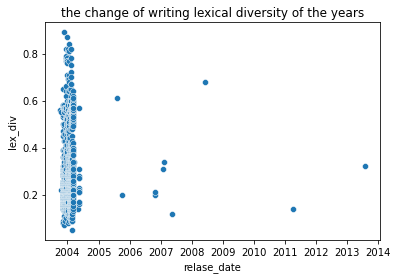

In [36]:
sns.scatterplot(x='relase_date', y='lex_div', data=df)
plt.title("the change of writing lexical diversity of the years")

<p>In the above diagram, I tried to detect the rate of lexical diversity over the years but unfortunately, the relase date is the date of convert the book to E-book and as we noticed most books are released at 2004</p>

### What is the most repeated word in all books?

In [37]:
most_repeated = df.most_repeated_words.values.flatten()
most_repeated[:10]

array([list([[32, 'laudius'], [25, 'one'], [21, 'made'], [19, 'ootnote'], [15, 'man'], [14, 'know'], [13, 'see'], [13, 'say'], [13, 'hat'], [13, 'day']]),
       list([[174, 'could'], [155, 'time'], [145, 'seemed'], [144, 'hen'], [142, 'great'], [132, 'came'], [125, 'upon'], [124, 'though'], [122, 'saw'], [115, 'sun']]),
       list([[420, 'one'], [225, 'would'], [214, 'always'], [207, 'much'], [186, 'quite'], [172, 'people'], [172, 'many'], [170, 'great'], [147, 'well'], [137, 'went']]),
       list([[280, 'man'], [269, 'one'], [230, 'work'], [217, 'life'], [196, 'world'], [185, 'men'], [146, 'great'], [132, 'shall'], [127, 'must'], [124, 'day']]),
       list([[291, 'one'], [196, 'would'], [167, 'rahmin'], [146, 'could'], [145, 'time'], [138, 'earth'], [136, 'moon'], [133, 'said'], [122, 'great'], [115, 'man']]),
       list([[73, 'thou'], [38, 'love'], [35, 'one'], [31, 'time'], [30, 'thy'], [28, 'thee'], [28, 'ever'], [26, 'many'], [25, 'would'], [24, 'well']]),
       list([[356, 

In [38]:
number = []
word = []
for lis in most_repeated :
    for elem in lis:
        number.append(elem[0])
        word.append(elem[1])

In [39]:
#construct new data frame to have the ability to use data frame build in functions.
most_rep_df = pd.DataFrame({'word':word,'number':number})

In [40]:
most_rep_df.head()

,word,number
0,laudius,32
1,one,25
2,made,21
3,ootnote,19
4,man,15


In [41]:
most_rep_coll = most_rep_df.groupby(word).sum()

In [42]:
top_repeated_words = most_rep_coll.sort_values('number',ascending=False)
top_repeated_words.head(10)

,number
one,193623
would,134788
said,126692
man,72394
upon,59492
could,51574
little,36986
may,36251
time,35887
like,33009


In [43]:
n_rep_wor = top_repeated_words[:10].index
#to_numpy return values as an array so i have to flattern it and then construct finall list.
words = [x for x in top_repeated_words[:10].to_numpy().flatten()]

Text(0.5, 1.0, 'most repeated words')

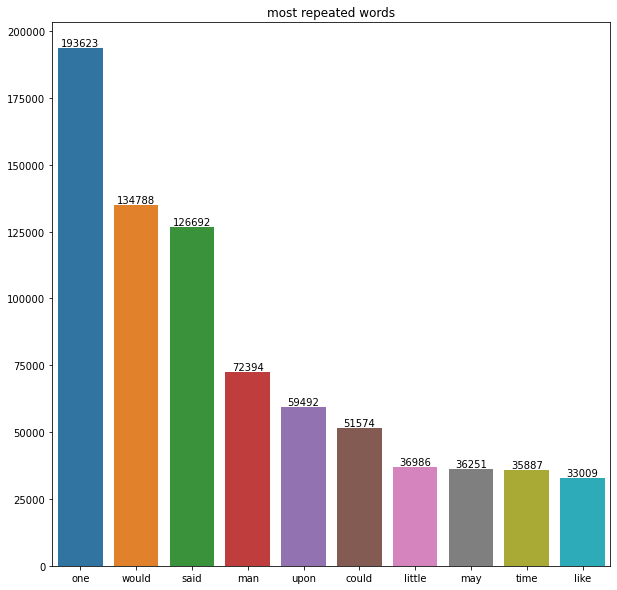

In [44]:
plt.figure(figsize=(10, 10))
plot = sns.barplot( x = n_rep_wor, y= words)
plt.bar_label(plot.containers[0])
plt.title("most repeated words")

### At the last part we are going to use Sentiment analysis by VADER for top writer 'W.W. Jacobs'

In [45]:
#got all his books from, books dictionary we already created
# 1 - we will get the index data frame which is a file numbers
jacobs_df = df[df.Author == 'W.W. Jacobs']
jacobs_df.head()

,title,Author,relase_date,n_words,n_unique,lex_div,most_repeated_words,n_hapaxes
10561,Fine Feathers,W.W. Jacobs,2004-01-01,1881,989,0.53,"[[77, obson], [76, said], [22, wife], [16, mot...",681
10562,Friends In Need,W.W. Jacobs,2004-01-01,1869,931,0.50,"[[101, said], [59, idd], [55, ibbs], [35, rown...",630
10563,Good Intentions,W.W. Jacobs,2004-01-01,1819,718,0.39,"[[75, ses], [25, one], [24, got], [23, wot], [...",423
10564,Fairy Gold,W.W. Jacobs,2004-01-01,1855,971,0.52,"[[69, eak], [59, said], [48, hase], [23, wife]...",679
10565,Watch-Dogs,W.W. Jacobs,2004-01-01,1844,721,0.39,"[[62, ses], [42, unnett], [26, wot], [22, rett...",428


In [46]:
jacobs_list = list(jacobs_df.index) #get files of ww jacobs

In [47]:
#construct dictionary contain only jacob files
get_files()   #to construct books dictinary again with generators, because we already feteched all generator to get data about all books
jacobs_files = {key:books[key] for key in jacobs_list }


In [48]:
analyser = SentimentIntensityAnalyzer()

In [49]:
jscore = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0}  #construct dictionary to save scores inside it.

In [50]:
for ind,file in jacobs_files.items():
    sentence_toknize = tokenization(file,'s')
    for book in sentence_toknize:
        score = analyser.polarity_scores(book)
        jscore['neg'] += score['neg']
        jscore['neu'] += score['neu']
        jscore['pos'] += score['pos']
    

In [51]:
print(jscore)

{'neg': 1456.781999999999, 'neu': 21917.78600000014, 'pos': 1929.4589999999978}


Text(0.5, 1.0, 'The main attribute for WW jacons writing')

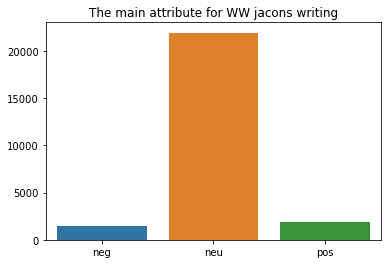

In [52]:
sns.barplot(x=list(jscore.keys()),y=list(jscore.values()))
plt.title("The main attribute for WW jacons writing")

- As we noticed the writing style for ww.jacob is natural.

##  Suggestions
<p>while making the analysis I tried to get the original publishing date but I found it hard to extract it because there is no certain pattern for it, they write one as year only, and others years and months, and there is no fixed place for it, we can use this data to show the development of using language throughout years.</p>
<p>Also, it will be good to find a way to know the genre for each novel, to classify it</p>
<p>Finally, in the versions of the modern books it will be good to add the number of sales for each book, maybe connect the Gutenburg site with E-book market places like amazon via API, and we can use this information to know if this style of book or those combination of worlds will get success or not.</p>

## Bibliography
* module materials
* https://pandas.pydata.org/
* https://numpy.org/
* https://seaborn.pydata.org/
* https://matplotlib.org/
* Wes McKinney (2022) Python for Data Analysis. 3rd ed. 1005 Gravenstein Highway North, Sebastopol, CA 95472.: O’Reilly Media, Inc.